<h1>Applied Data Science Capstone</h1>
<h2>Description</h2>
<p>This notebook will be mainly used to complete the project on the IBMs final course "Applied Data Science Capstone".</p>
<p>Our objective is to construct a model for predicting the severity of an accident in order to warn drivers of the risks they might face in real-time</p>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sps
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy.stats import kendalltau
from scipy.stats import chi2_contingency
from scipy.stats import describe
import matplotlib as mpl
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import jaccard_score, f1_score, log_loss, confusion_matrix
import itertools
import folium
pd.options.mode.chained_assignment = None

In [2]:
print("Hello Capstone Project Course!")

Hello Capstone Project Course!


<h2>Definitions</h2>

In [3]:
def cramers_v(x,y):
    cont_tab = pd.crosstab(x,y)
    chi2 = chi2_contingency(cont_tab)
    return np.sqrt((chi2[0]/x.shape[0])/np.min([cont_tab.shape[0]-1, cont_tab.shape[1]-1]))

In [4]:
def cat2num(un, df, col):
    i = 0
    for val in un:
        df[col] = df[col].replace(val, i)
        i = i + 1
    return df, pd.DataFrame({"categorical": un, "numerical": pd.unique(df[col])})

<h2>Data Understanding & Preparation</h2>
<p>In this section we will choose features that can be used for our purpose, explore relationships in order to understand each feature and process the data so that it can be used in the model</p>

In [5]:
df = pd.read_csv("Data-Collisions.csv", low_memory=False)

In [6]:
df.dtypes

SEVERITYCODE        int64
X                 float64
Y                 float64
OBJECTID            int64
INCKEY              int64
COLDETKEY           int64
REPORTNO           object
STATUS             object
ADDRTYPE           object
INTKEY            float64
LOCATION           object
EXCEPTRSNCODE      object
EXCEPTRSNDESC      object
SEVERITYCODE.1      int64
SEVERITYDESC       object
COLLISIONTYPE      object
PERSONCOUNT         int64
PEDCOUNT            int64
PEDCYLCOUNT         int64
VEHCOUNT            int64
INCDATE            object
INCDTTM            object
JUNCTIONTYPE       object
SDOT_COLCODE        int64
SDOT_COLDESC       object
INATTENTIONIND     object
UNDERINFL          object
WEATHER            object
ROADCOND           object
LIGHTCOND          object
PEDROWNOTGRNT      object
SDOTCOLNUM        float64
SPEEDING           object
ST_COLCODE         object
ST_COLDESC         object
SEGLANEKEY          int64
CROSSWALKKEY        int64
HITPARKEDCAR       object
dtype: objec

<p>Firstly we have to remove unimportant columns which clearly don't contribute on the prediction of accident severity. The following list shows such columns.</p>
<ul>
    <li>OBJECTID</li>
    <li>INCKEY</li>
    <li>COLDETKEY</li>
    <li>REPORTNO</li>
</ul>
<p>The question we are going to ask is which features can be obtained in real-time so that we can make predictions for the drivers. At first glance we can see a few columns containing data that can be obtained using gps, news etc.</p>
<ul>
    <li>WEATHER: Current weather. We can use weather forecasts to obtain this data in real-time.</li>
    <li>SPEEDING: Car crossing the speed threshold. Speedometers can provide this type of information</li>
    <li>LIGHTCOND: Whether it's daylight or night or perhaps there are clouds. Sensors could help us obtain this information.</li>
    <li>ROADCOND: The condition of the road. We could use news reports to obtain it, for instance if there was a rain a few hours ago at a specific location, the road is going to be wet.</li>
    <li>JUNCTIONTYPE: Type of junction. Use a gps to obtain the information.</li>
    <li>ADDRTYPE: Whether the car is at an intersection, block etc. Use a gps to obtain the information.</li>
    <li>INTKEY: The type of the intersection given that the car is at an intersection. Use a gps to obtain the information.</li>
    <li>INCDTTM: Date and time</li>
    <li>PEDROWNOTGRNT: Give-way for pedestrians. This should be turned to a binary feature. Gps can provide this information.</li>
    <li>HITPARKEDCAR: Whether an accident involved parked cars. We should turn it into a binary feature of whether there were parked cars involved. Information can be obtained by observing every road and determine if there are cars usually parked at the sides.</li>
    <li>X,Y: Lat and lon giving the exact location of the accident. We can use a gps for this one.</li>
    <li>SEGLANEKEY: A key of the segment where the accident occured if it. This information could be embedded in the gps</li>
    <li>CROSSWALKKEY: A key of the crosswalk the accident occured. This information could be embedded in the gps</li>
    <li>PEDCYLCOUNT: The number of bicycles involved. This can be used as a binary feature of whether or not there were bicycles involved. In practice we could obtain this information by observing the frequency of bicycles passing from specific locations and saving the statistics in a gps.</li>
    <li>PEDCOUNT: The number of pedestrians involved in the accident. This should be used as a binary feature of whether there were pedestrians involved or not. Again we could use a gps to set locations of higher pedestrian count which would increase the probability of pedestrians being involved in an accident.</li>
    <li>VEHCOUNT: The number of vehicles involved. This will also be a binary value and the way to obtain the data in real-time is similar to that of PEDCOUNT.</li>
</ul>
<p>I have given some ideas for obtaining real-time data from the above list of features. I don't claim that all of them can be applied in reality since i have never being involved with the subject.</p>
<p>For the remaining columns i believe that even though they could be correlated to accident severity, they can't be used in real-time for making predictions. For instance INATTENTIONIND shows whether the accident occured due to inattention but how can we determine the attention level of the driver or the other drivers in the road? For that reason we will not study these columns.</p>
<p>Let's make a new dataframe which will only include the columns we are going to use</p>

In [7]:
lab_enc = LabelEncoder()
scaler = StandardScaler()

In [8]:
df_p = df[["SEVERITYCODE","X","Y","WEATHER","SPEEDING","LIGHTCOND","ROADCOND","JUNCTIONTYPE","ADDRTYPE","INTKEY","INCDTTM","PEDROWNOTGRNT","HITPARKEDCAR","SEGLANEKEY","CROSSWALKKEY","PEDCYLCOUNT","PEDCOUNT","VEHCOUNT"]]
df_p.shape

(194673, 18)

<p>We will now look into each feature</p>

<p>Let's check the percentage of severe and minor cases in the whole dataset, ~70% of the accidents were minor while ~30% where severe. We will fix the unbalanced data issue later. For now let's look into the dataset</p>

In [9]:
df_p["SEVERITYCODE"].value_counts()/df_p.shape[0]

1    0.701099
2    0.298901
Name: SEVERITYCODE, dtype: float64

<h4>WEATHER</h4>
<p>For this feature we will drop all nan values and also the value "Unknown". We will then convert categorical values to numeric</p>

In [10]:
print("NaN values: ",df_p[df_p["WEATHER"].isnull()].shape[0])
df_p["WEATHER"].value_counts().to_frame()

NaN values:  5081


,WEATHER
Clear,111135
Raining,33145
Overcast,27714
Unknown,15091
Snowing,907
Other,832
Fog/Smog/Smoke,569
Sleet/Hail/Freezing Rain,113
Blowing Sand/Dirt,56
Severe Crosswind,25


<p>For the bottom 2 weather categories there are very few data points for them to give statisticaly significant results so we are going to convert them into "Other" instead</p>

In [11]:
# drop nan values and "unknown" value
df_p["WEATHER"] = df_p["WEATHER"].replace("Unknown", np.nan)
df_p["WEATHER"] = df_p["WEATHER"].replace("Partly Cloudy", "Other")
df_p["WEATHER"] = df_p["WEATHER"].replace("Severe Crosswind", "Other")
df_p["WEATHER"] = df_p["WEATHER"].replace("Severe Crosswind", "Other")
df_p.dropna(subset=["WEATHER"], axis=0, inplace=True)
print("NaN values: ",df_p[df_p["WEATHER"].isnull()].shape[0])

NaN values:  0


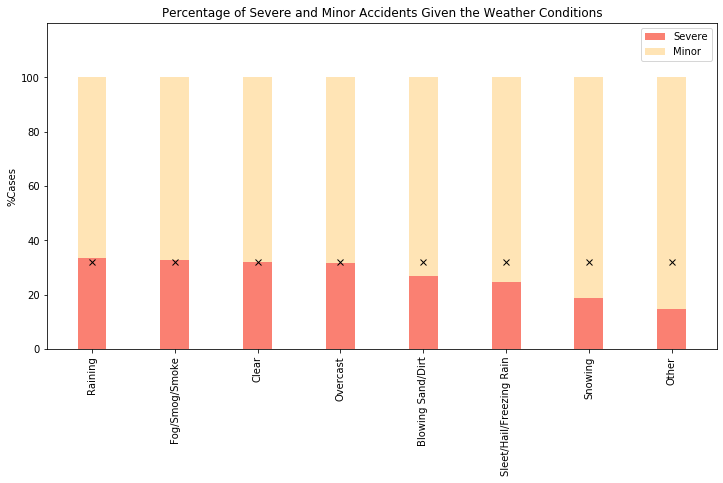

In [12]:
# show relationship to severe accidents
df_plt = df_p[df_p["SEVERITYCODE"] == 2][["WEATHER","SEVERITYCODE"]].groupby(["WEATHER"]).count()
df_plt.columns = ["severe_count"]
df_plt["minor_count"] = df_p[df_p["SEVERITYCODE"] == 1][["WEATHER","SEVERITYCODE"]].groupby(["WEATHER"]).count()
df_plt["severe%"] = (df_plt["severe_count"]/(df_plt["severe_count"] + df_plt["minor_count"]))*100
df_plt["minor%"] = (df_plt["minor_count"]/(df_plt["severe_count"] + df_plt["minor_count"]))*100
df_plt.sort_values(by=["severe%"], ascending=False, inplace=True)


w = 0.35
plt.figure(figsize=(12,6))
ax1 = plt.bar(df_plt.index, df_plt["severe%"], color="salmon", width=w, label="Severe")
ax2 = plt.bar(df_plt.index, df_plt["minor%"], color="#FFE4B5", bottom=df_plt["severe%"], width=w, label="Minor")
for i in range(0,8):
    plt.plot(i, 100*df_p["SEVERITYCODE"].value_counts()[2]/df_p.shape[0], color="black", marker="x")
plt.ylabel("%Cases")
plt.xticks(df_plt.index, rotation="vertical")
plt.title("Percentage of Severe and Minor Accidents Given the Weather Conditions")
plt.legend(loc="best")
plt.ylim(0,120)
plt.yticks(range(0,120,20))
plt.savefig("weather_severe_minor_barchart.png")
plt.show()

<p>The above graph compares the amount of severe against the amount of minor accidents for each weather category. The point marked as 'x' is the percentage of severe cases in the whole dataset (~30%) which we have computed earlier.</p>
<p>According to the definition of naive probability, the probability of an accident being severe is equal to the number of severe observations in the dataset divided by the total number of observations in the dataset, therefore the probability of having a severe accident is about 0.3 in general.</p>
<p>The conditional probability of an accident being severe given the type of weather is illustrated in the graph above. If the conditional probability of severe accidents given a certain type of weather is much greater or much lower than the general probability then this should indicate that the specified weather condition will be more significant in determining whether the accident will be severe or not</p>
<p>Therefore we care about those weather categories that are further away from the 'x' point</p>
<p>Lastly, we are going to convert the categories into numeric values</p>

In [13]:
# convert categorical to numeric

cat = pd.unique(df_plt.index)
lab_enc.fit(df_plt.index)
df_p["WEATHER"] = lab_enc.transform(df_p["WEATHER"])
weather_cat = pd.DataFrame({"categorical": cat,"numeric": pd.unique(df_p["WEATHER"])})


In [14]:

df_p["WEATHER"] = df_p["WEATHER"].replace(4, 1)
df_p["WEATHER"] = df_p["WEATHER"].replace(5, 1)
weather_cat


,categorical,numeric
0,Raining,4
1,Fog/Smog/Smoke,5
2,Clear,1
3,Overcast,3
4,Blowing Sand/Dirt,7
5,Sleet/Hail/Freezing Rain,2
6,Snowing,6
7,Other,0


<h4>SPEEDING</h4>

<p>Whether or not the car invlolved in the accident was speeding. We need this feature to be binary and clean up any nan values that may exist</p>

In [15]:
print("NaN values: ",df_p[df_p["SPEEDING"].isnull()].shape[0])
df_p["SPEEDING"].value_counts().to_frame()

NaN values:  165274


,SPEEDING
Y,9227


<p>There is only 1 possible value this feature takes, 'Y' which most probably means 'YES'. Knowing that and the fact that there are alot NaN values perhaps they've only recorded the cases where there was speeding involved leaving the rest of them empty. That could mean that the NaN values should actually be equal to 'N' which stands for 'NO'.</p> 

In [16]:
df_p["SPEEDING"] = df_p["SPEEDING"].replace(np.nan, "N")
print("NaN values: ",df_p[df_p["SPEEDING"].isnull()].shape[0])

NaN values:  0


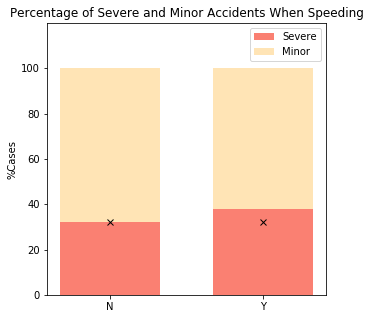

In [17]:
# show relationship to severe accidents
df_plt = df_p[df_p["SEVERITYCODE"] == 2][["SPEEDING","SEVERITYCODE"]].groupby(["SPEEDING"]).count()
df_plt.columns = ["severe_count"]
df_plt["minor_count"] = df_p[df_p["SEVERITYCODE"] == 1][["SPEEDING","SEVERITYCODE"]].groupby(["SPEEDING"]).count()
df_plt["severe%"] = (df_plt["severe_count"]/(df_plt["severe_count"] + df_plt["minor_count"]))*100
df_plt["minor%"] = (df_plt["minor_count"]/(df_plt["severe_count"] + df_plt["minor_count"]))*100

w = 0.65
plt.figure(figsize=(5,5))
ax1 = plt.bar(df_plt.index, df_plt["severe%"], color="salmon", width=w, label="Severe")
ax2 = plt.bar(df_plt.index, df_plt["minor%"], color="#FFE4B5", bottom=df_plt["severe%"], width=w, label="Minor")
for i in range(0,2):
    plt.plot(i, 100*df_p["SEVERITYCODE"].value_counts()[2]/df_p.shape[0], color="black", marker="x")
plt.ylabel("%Cases")
plt.xticks(df_plt.index)
plt.title("Percentage of Severe and Minor Accidents When Speeding")
plt.legend(loc="best")
plt.ylim(0,120)
plt.yticks(range(0,120,20))
plt.savefig("weather_severe_minor_barchart.png")
plt.show()

<p>The meaning of the above bar chart is similar to that of the previous feature. We can see that when the cars involved in an accident are speeding the probability of having a severe accident is greater than usual</p>

<p>Now we will convert the values ['Y','N'] to [1,0]</p>

In [18]:
df_p["SPEEDING"] = df_p["SPEEDING"].replace(["Y","N"], [1, 0])

<h4>LIGHTCOND</h4>
<p>Let's look into the light conditions</p>

In [19]:
print("NaN values: ",df_p[df_p["LIGHTCOND"].isnull()].shape[0])
df_p["LIGHTCOND"].value_counts().to_frame()

NaN values:  166


,LIGHTCOND
Daylight,113542
Dark - Street Lights On,47120
Dusk,5710
Unknown,2755
Dawn,2437
Dark - No Street Lights,1432
Dark - Street Lights Off,1122
Other,206
Dark - Unknown Lighting,11


<p>We are going to remove the nan values as well as the "Unknown" value. Next we will move "Dark-Unknown Lighting" to "Other" since it only contains 11 observations, not enough to create statisticaly significant results</p>

In [20]:
df_p["LIGHTCOND"] = df_p["LIGHTCOND"].replace("Unknown", np.nan)
df_p.dropna(subset=["LIGHTCOND"], axis=0, inplace=True)
df_p["LIGHTCOND"] = df_p["LIGHTCOND"].replace("Dark - Unknown Lighting", "Other")
print("NaN values: ",df_p[df_p["LIGHTCOND"].isnull()].shape[0])

NaN values:  0


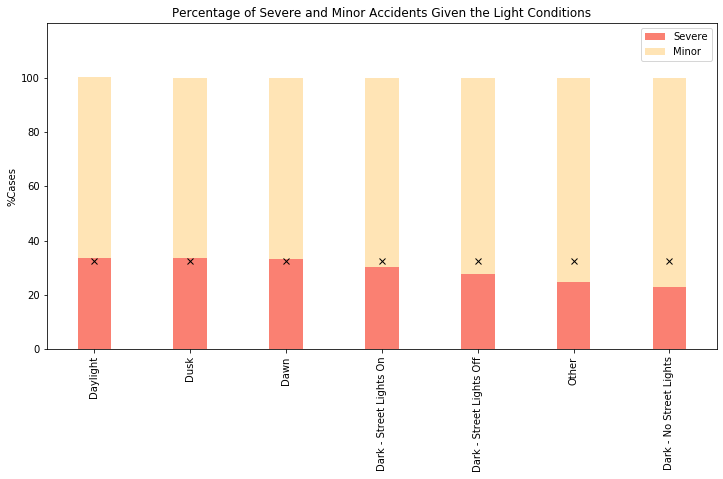

In [21]:
# show relationship to severe accidents
df_plt = df_p[df_p["SEVERITYCODE"] == 2][["LIGHTCOND","SEVERITYCODE"]].groupby(["LIGHTCOND"]).count()
df_plt.columns = ["severe_count"]
df_plt["minor_count"] = df_p[df_p["SEVERITYCODE"] == 1][["LIGHTCOND","SEVERITYCODE"]].groupby(["LIGHTCOND"]).count()
df_plt["severe%"] = (df_plt["severe_count"]/(df_plt["severe_count"] + df_plt["minor_count"]))*100
df_plt["minor%"] = (df_plt["minor_count"]/(df_plt["severe_count"] + df_plt["minor_count"]))*100
df_plt.sort_values(by=["severe%"], ascending=False, inplace=True)

w = 0.35
plt.figure(figsize=(12,6))
ax1 = plt.bar(df_plt.index, df_plt["severe%"], color="salmon", width=w, label="Severe")
ax2 = plt.bar(df_plt.index, df_plt["minor%"], color="#FFE4B5", bottom=df_plt["severe%"], width=w, label="Minor")
for i in range(0,7):
    plt.plot(i, 100*df_p["SEVERITYCODE"].value_counts()[2]/df_p.shape[0], color="black", marker="x")
plt.ylabel("%Cases")
plt.xticks(df_plt.index, rotation="vertical")
plt.title("Percentage of Severe and Minor Accidents Given the Light Conditions")
plt.legend(loc="best")
plt.ylim(0,120)
plt.yticks(range(0,120,20))
plt.savefig("weather_severe_minor_barchart.png")
plt.show()

<p>Finally we will convert categorical values into numeric values</p>

In [22]:

cat = pd.unique(df_plt.index)
lab_enc.fit(df_plt.index)
df_p["LIGHTCOND"] = lab_enc.transform(df_p["LIGHTCOND"])
lightcond_cat = pd.DataFrame({"categorical": cat, "numerical": pd.unique(df_p["LIGHTCOND"])})
lightcond_cat

,categorical,numerical
0,Daylight,4
1,Dusk,2
2,Dawn,0
3,Dark - Street Lights On,5
4,Dark - Street Lights Off,3
5,Other,1
6,Dark - No Street Lights,6


<h4>ROADCOND</h4>

In [23]:
print("NaN values: ",df_p[df_p["ROADCOND"].isnull()].shape[0])
df_p["ROADCOND"].value_counts().to_frame()

NaN values:  32


,ROADCOND
Dry,121754
Wet,46469
Ice,1096
Unknown,1038
Snow/Slush,845
Other,111
Standing Water,108
Sand/Mud/Dirt,66
Oil,61


<p>We will drop all NaN values</p>

In [24]:
df_p["ROADCOND"] = df_p["ROADCOND"].replace("Unknown", np.nan)
df_p.dropna(subset=["ROADCOND"], axis=0, inplace=True)
print("NaN values: ",df_p[df_p["ROADCOND"].isnull()].shape[0])

NaN values:  0


<p>The values of this feature suggest that there might be some correlation with the weather conditions</p>

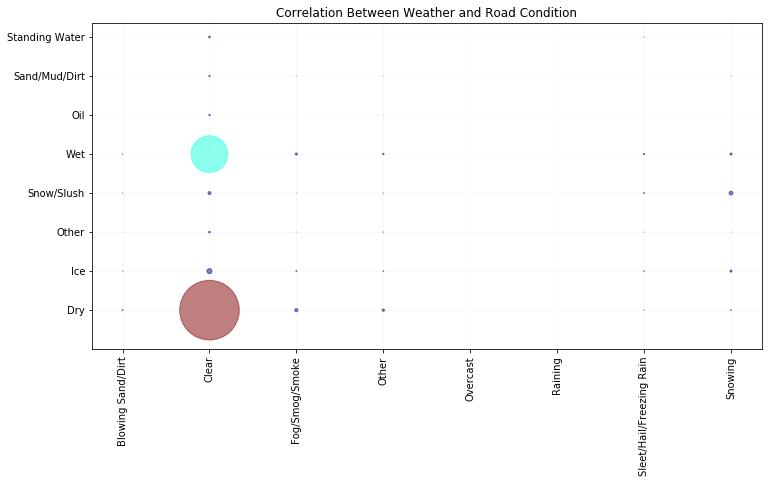

In [25]:

df_plt = df_p[["WEATHER", "ROADCOND"]]
df_plt["count"] = np.ones(df_plt.shape[0])
df_plt_grp = df_plt.groupby(["WEATHER","ROADCOND"]).count()/df_plt.shape[0]
x = []
y = []
count = []
color = []
for i in range(df_plt_grp.shape[0]):
    x.append(df_plt_grp.index[i][0])
    y.append(df_plt_grp.index[i][1])
    count.append(df_plt_grp["count"].values[i]*5000)
    color.append(df_plt_grp["count"].values[i])
    
plt.figure(figsize=(12,6))
plt.scatter(x, y, s=count, alpha=0.5, c=color, cmap=plt.get_cmap('jet'))
plt.xticks(range(0,weather_cat["categorical"].shape[0]), weather_cat["categorical"].sort_values().values, rotation="vertical")
plt.ylim(-1,)
plt.grid(alpha=0.1)
plt.title("Correlation Between Weather and Road Condition")
plt.show()

<p>The bubble plot indicates some correlation between values such as ("ROADCOND", "WEATHER") = ("Dry", "Clear") and ("ROADCOND", "WEATHER") = ("Wet", "Raining") but this isn't enough to suggest removing one of the features since some values like "ROADCOND" = "Standing Water" or "WEATHER" = "Fog/Smog/Smoke" have no ("ROADCOND", "WEATHER") pair with strong enough correlation.</p>
<p>Now we will look into the severity% of each category</p>

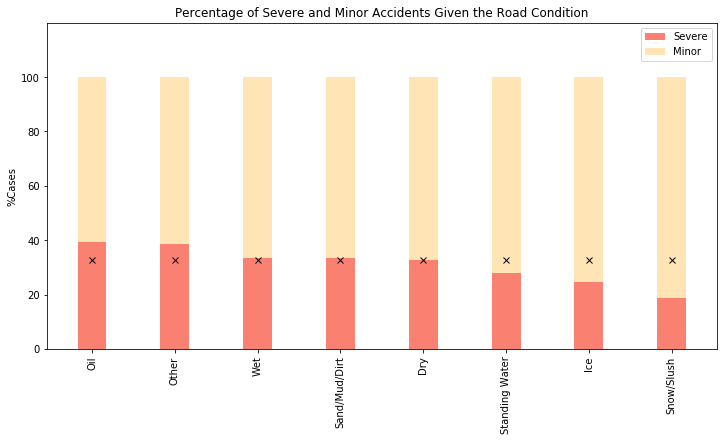

In [26]:
# show relationship to severe accidents
df_plt = df_p[df_p["SEVERITYCODE"] == 2][["ROADCOND","SEVERITYCODE"]].groupby(["ROADCOND"]).count()
df_plt.columns = ["severe_count"]
df_plt["minor_count"] = df_p[df_p["SEVERITYCODE"] == 1][["ROADCOND","SEVERITYCODE"]].groupby(["ROADCOND"]).count()
df_plt["severe%"] = (df_plt["severe_count"]/(df_plt["severe_count"] + df_plt["minor_count"]))*100
df_plt["minor%"] = (df_plt["minor_count"]/(df_plt["severe_count"] + df_plt["minor_count"]))*100
df_plt.sort_values(by=["severe%"], ascending=False, inplace=True)

w = 0.35
plt.figure(figsize=(12,6))
ax1 = plt.bar(df_plt.index, df_plt["severe%"], color="salmon", width=w, label="Severe")
ax2 = plt.bar(df_plt.index, df_plt["minor%"], color="#FFE4B5", bottom=df_plt["severe%"], width=w, label="Minor")
for i in range(0,8):
    plt.plot(i, 100*df_p["SEVERITYCODE"].value_counts()[2]/df_p.shape[0], color="black", marker="x")
plt.ylabel("%Cases")
plt.xticks(df_plt.index, rotation="vertical")
plt.title("Percentage of Severe and Minor Accidents Given the Road Condition")
plt.legend(loc="best")
plt.ylim(0,120)
plt.yticks(range(0,120,20))
plt.show()

<p>Finally we will convert all categorical values into numerical</p>

In [27]:

cat = pd.unique(df_plt.index)
lab_enc.fit(df_plt.index)
df_p["ROADCOND"] = lab_enc.transform(df_p["ROADCOND"])
roadcond_cat = pd.DataFrame({"categorical": cat, "numeric": pd.unique(df_p["ROADCOND"])})
roadcond_cat


,categorical,numeric
0,Oil,7
1,Other,0
2,Wet,5
3,Sand/Mud/Dirt,1
4,Dry,3
5,Standing Water,4
6,Ice,6
7,Snow/Slush,2


<h4>JUNCTIONTYPE</h4>

In [28]:
print("NaN values: ",df_p[df_p["JUNCTIONTYPE"].isnull()].shape[0])
df_p["JUNCTIONTYPE"].value_counts().to_frame()

NaN values:  2507


,JUNCTIONTYPE
Mid-Block (not related to intersection),75325
At Intersection (intersection related),59521
Mid-Block (but intersection related),21215
Driveway Junction,9981
At Intersection (but not related to intersection),1798
Ramp Junction,157
Unknown,6


<p>Remove nan values and unknown value</p>

In [29]:
df_p["JUNCTIONTYPE"] = df_p["JUNCTIONTYPE"].replace("Unknown", np.nan)
df_p.dropna(subset=["JUNCTIONTYPE"], axis=0, inplace=True)
print("NaN values: ",df_p[df_p["JUNCTIONTYPE"].isnull()].shape[0])

NaN values:  0


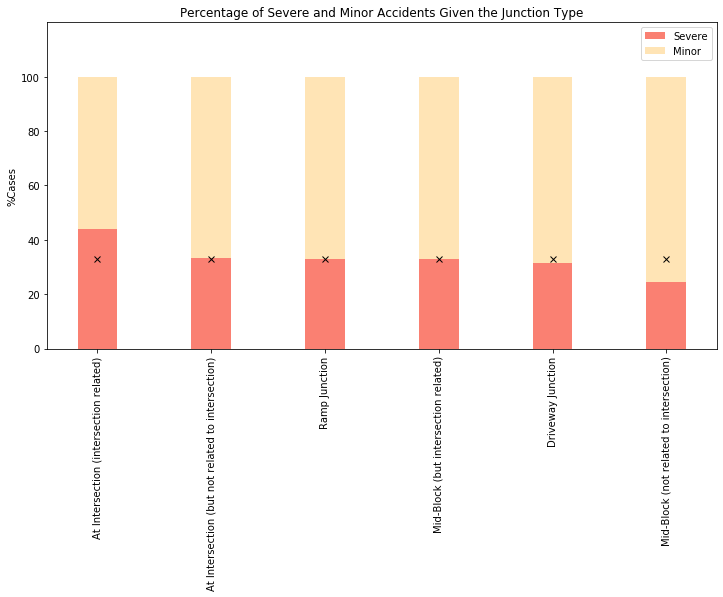

In [30]:
# show relationship to severe accidents
df_plt = df_p[df_p["SEVERITYCODE"] == 2][["JUNCTIONTYPE","SEVERITYCODE"]].groupby(["JUNCTIONTYPE"]).count()
df_plt.columns = ["severe_count"]
df_plt["minor_count"] = df_p[df_p["SEVERITYCODE"] == 1][["JUNCTIONTYPE","SEVERITYCODE"]].groupby(["JUNCTIONTYPE"]).count()
df_plt["severe%"] = (df_plt["severe_count"]/(df_plt["severe_count"] + df_plt["minor_count"]))*100
df_plt["minor%"] = (df_plt["minor_count"]/(df_plt["severe_count"] + df_plt["minor_count"]))*100
df_plt.sort_values(by=["severe%"], ascending=False, inplace=True)

w = 0.35
plt.figure(figsize=(12,6))
ax1 = plt.bar(df_plt.index, df_plt["severe%"], color="salmon", width=w, label="Severe")
ax2 = plt.bar(df_plt.index, df_plt["minor%"], color="#FFE4B5", bottom=df_plt["severe%"], width=w, label="Minor")
for i in range(0,6):
    plt.plot(i, 100*df_p["SEVERITYCODE"].value_counts()[2]/df_p.shape[0], color="black", marker="x")
plt.ylabel("%Cases")
plt.xticks(df_plt.index, rotation="vertical")
plt.title("Percentage of Severe and Minor Accidents Given the Junction Type")
plt.legend(loc="best")
plt.ylim(0,120)
plt.yticks(range(0,120,20))
plt.show()

In [31]:

cat = pd.unique(df_plt.index)
lab_enc.fit(df_plt.index)
df_p["JUNCTIONTYPE"] = lab_enc.transform(df_p["JUNCTIONTYPE"])
junctiontype_cat = pd.DataFrame({"categorical": cat, "numeric": pd.unique(df_p["JUNCTIONTYPE"])})
junctiontype_cat


,categorical,numeric
0,At Intersection (intersection related),1
1,At Intersection (but not related to intersection),4
2,Ramp Junction,2
3,Mid-Block (but intersection related),3
4,Driveway Junction,0
5,Mid-Block (not related to intersection),5


<h4>ADDRTYPE</h4>

In [32]:
print("NaN values: ",df_p[df_p["ADDRTYPE"].isnull()].shape[0])
df_p["ADDRTYPE"].value_counts().to_frame()

NaN values:  140


,ADDRTYPE
Block,106344
Intersection,61331
Alley,182


In [33]:
df_p.dropna(subset=["ADDRTYPE"], axis=0, inplace=True)
print("NaN values: ",df_p[df_p["ADDRTYPE"].isnull()].shape[0])

NaN values:  0


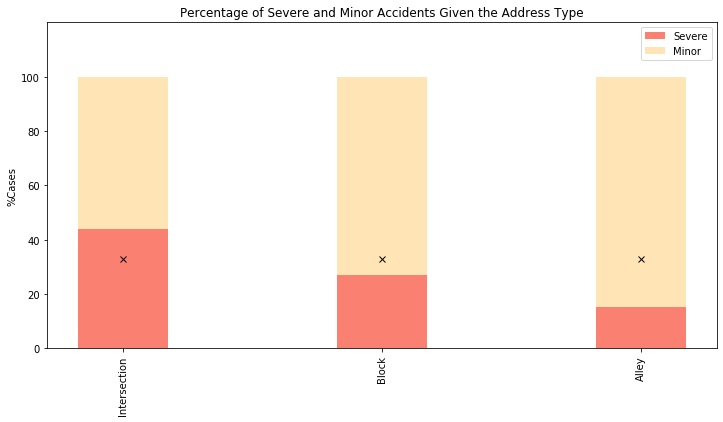

In [34]:
# show relationship to severe accidents
df_plt = df_p[df_p["SEVERITYCODE"] == 2][["ADDRTYPE","SEVERITYCODE"]].groupby(["ADDRTYPE"]).count()
df_plt.columns = ["severe_count"]
df_plt["minor_count"] = df_p[df_p["SEVERITYCODE"] == 1][["ADDRTYPE","SEVERITYCODE"]].groupby(["ADDRTYPE"]).count()
df_plt["severe%"] = (df_plt["severe_count"]/(df_plt["severe_count"] + df_plt["minor_count"]))*100
df_plt["minor%"] = (df_plt["minor_count"]/(df_plt["severe_count"] + df_plt["minor_count"]))*100
df_plt.sort_values(by=["severe%"], ascending=False, inplace=True)

w = 0.35
plt.figure(figsize=(12,6))
ax1 = plt.bar(df_plt.index, df_plt["severe%"], color="salmon", width=w, label="Severe")
ax2 = plt.bar(df_plt.index, df_plt["minor%"], color="#FFE4B5", bottom=df_plt["severe%"], width=w, label="Minor")
for i in range(0,3):
    plt.plot(i, 100*df_p["SEVERITYCODE"].value_counts()[2]/df_p.shape[0], color="black", marker="x")
plt.ylabel("%Cases")
plt.xticks(df_plt.index, rotation="vertical")
plt.title("Percentage of Severe and Minor Accidents Given the Address Type")
plt.legend(loc="best")
plt.ylim(0,120)
plt.yticks(range(0,120,20))
plt.show()

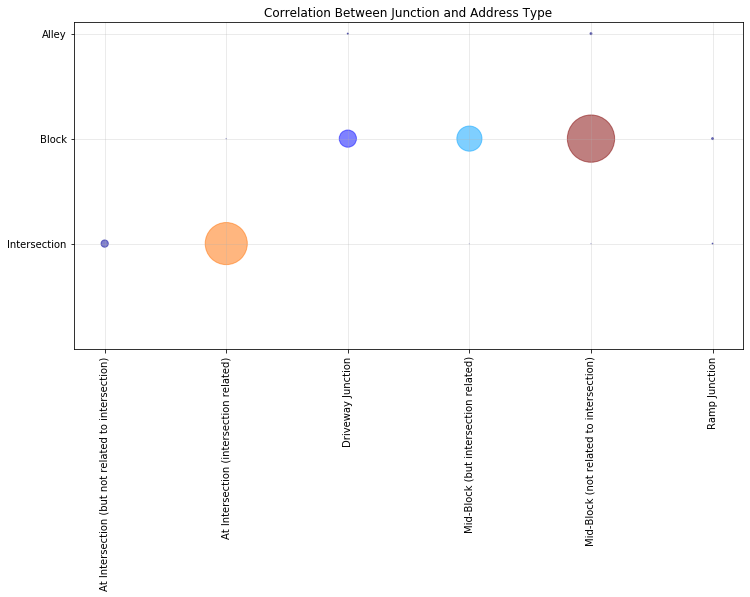

In [35]:
df_plt = df_p[["JUNCTIONTYPE", "ADDRTYPE"]]
df_plt["count"] = np.ones(df_plt.shape[0])
df_plt_grp = df_plt.groupby(["JUNCTIONTYPE","ADDRTYPE"]).count()/df_plt.shape[0]
x = []
y = []
count = []
color = []
for i in range(df_plt_grp.shape[0]):
    x.append(df_plt_grp.index[i][0])
    y.append(df_plt_grp.index[i][1])
    count.append(df_plt_grp["count"].values[i]*5000)
    color.append(df_plt_grp["count"].values[i])
    
plt.figure(figsize=(12,6))
plt.scatter(x, y, s=count, alpha=0.5, c=color, cmap=plt.get_cmap('jet'))
plt.xticks(range(0,junctiontype_cat["categorical"].shape[0]), junctiontype_cat["categorical"].sort_values().values, rotation="vertical")
plt.ylim(-1,)
plt.grid(alpha=0.3)
plt.title("Correlation Between Junction and Address Type")
plt.show()

<p>From the bubble plot above and the value of Kendall's Tau, we can see there is correlation between junction and address type. We can use one of these 2 features for our models training, probably junction type since it contains a bit more information</p>

In [36]:
# show relationship to severe accidents
df_plt = df_p[df_p["SEVERITYCODE"] == 2][["ADDRTYPE","SEVERITYCODE"]].groupby(["ADDRTYPE"]).count()
df_plt.columns = ["severe_count"]
df_plt["minor_count"] = df_p[df_p["SEVERITYCODE"] == 1][["ADDRTYPE","SEVERITYCODE"]].groupby(["ADDRTYPE"]).count()
df_plt["severe%"] = (df_plt["severe_count"]/(df_plt["severe_count"] + df_plt["minor_count"]))*100
df_plt["minor%"] = (df_plt["minor_count"]/(df_plt["severe_count"] + df_plt["minor_count"]))*100
df_plt.sort_values(by=["severe%"], ascending=False, inplace=True)

cat = pd.unique(df_plt.index)
lab_enc.fit(df_plt.index)
df_p["ADDRTYPE"] = lab_enc.transform(df_p["ADDRTYPE"])
addrtype_cat = pd.DataFrame({"categorical": cat, "numeric": pd.unique(df_p["ADDRTYPE"])})
addrtype_cat

,categorical,numeric
0,Intersection,2
1,Block,1
2,Alley,0


<h4>INTKEY</h4>

In [37]:
print("NaN values: ",df_p[df_p["INTKEY"].isnull()].shape[0])
print("Unique values: ",df_p["INTKEY"].value_counts().size)
df_p["INTKEY"].describe()

NaN values:  106526
Unique values:  7416


count     61331.000000
mean      37547.577815
std       51546.585117
min       23807.000000
25%       28689.000000
50%       29999.000000
75%       34008.000000
max      757580.000000
Name: INTKEY, dtype: float64

<p>We will convert all nan values into a separate category '0'. Since all data in column corresponds to intersection codes the nan values should be categorized as 'Non-itersection'</p>

In [38]:
df_p["INTKEY"] = df_p["INTKEY"].replace(np.nan, 0)
print("NaN values: ",df_p[df_p["INTKEY"].isnull()].shape[0])

NaN values:  0


In [39]:
# show relationship to severe accidents
df_plt = df_p[df_p["SEVERITYCODE"] == 2][["INTKEY","SEVERITYCODE"]].groupby(["INTKEY"]).count()
df_plt.columns = ["severe_count"]
df_plt["minor_count"] = df_p[df_p["SEVERITYCODE"] == 1][["INTKEY","SEVERITYCODE"]].groupby(["INTKEY"]).count()
df_plt["severe%"] = (df_plt["severe_count"]/(df_plt["severe_count"] + df_plt["minor_count"]))*100
df_plt["minor%"] = (df_plt["minor_count"]/(df_plt["severe_count"] + df_plt["minor_count"]))*100
df_plt.sort_values(by=["severe%"], ascending=False, inplace=True)

df_plt.index
df_p["INTKEY"] = df_p["INTKEY"].replace(df_plt.index, np.arange(df_plt.index.shape[0]))

<p>It is obvious that this feature is strongly correlated with the previous 2 features and that is because it contains information regarding the type of intersection if the accident happened on an intersection.</p>

<h4>INCDTTM</h4>

In [40]:
df_p["INCDTTM"].head(3)

0      3/27/2013 2:54:00 PM
1     12/20/2006 6:55:00 PM
2    11/18/2004 10:20:00 AM
Name: INCDTTM, dtype: object

In [41]:
df_p["INCDTTM"] = pd.to_datetime(df_p["INCDTTM"])
df_p["INCDTTM"].dtype

dtype('<M8[ns]')

In [42]:
print("NaN values: ",df_p[df_p["INCDTTM"].isnull()].shape[0])

NaN values:  0


<p>We will create 4 new columns, day, month, week, hour and drop this column since we won't be needing it anymore</p>

In [43]:
day = []
week = []
month = []
hour = []
for el in df_p["INCDTTM"]:
    day.append(el.day)
    week.append(el.dayofweek)
    month.append(el.month)
    hour.append(el.hour)
df_p["DAY"] = day
df_p["DAYOFWEEK"] = week
df_p["MONTH"] = month
df_p["HOUR"] = hour
df_p.drop(["INCDTTM"], axis=1, inplace=True)

<h4>HOUR</h4>

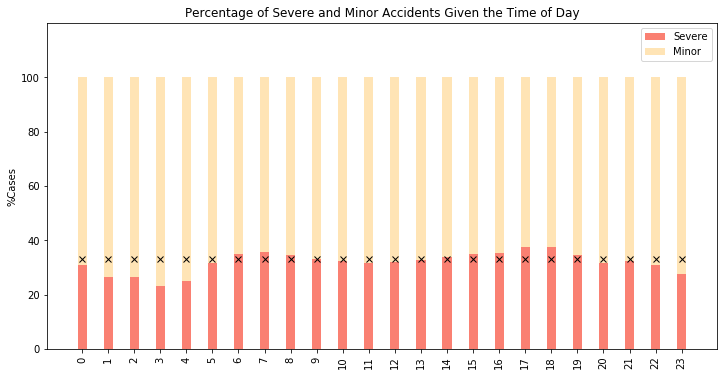

In [44]:
# show relationship to severe accidents
df_plt = df_p[df_p["SEVERITYCODE"] == 2][["HOUR","SEVERITYCODE"]].groupby(["HOUR"]).count()
df_plt.columns = ["severe_count"]
df_plt["minor_count"] = df_p[df_p["SEVERITYCODE"] == 1][["HOUR","SEVERITYCODE"]].groupby(["HOUR"]).count()
df_plt["severe%"] = (df_plt["severe_count"]/(df_plt["severe_count"] + df_plt["minor_count"]))*100
df_plt["minor%"] = (df_plt["minor_count"]/(df_plt["severe_count"] + df_plt["minor_count"]))*100
#df_plt.sort_values(by=["severe%"], ascending=False, inplace=True)

w = 0.35
plt.figure(figsize=(12,6))
ax1 = plt.bar(df_plt.index, df_plt["severe%"], color="salmon", width=w, label="Severe")
ax2 = plt.bar(df_plt.index, df_plt["minor%"], color="#FFE4B5", bottom=df_plt["severe%"], width=w, label="Minor")
for i in range(0,24):
    plt.plot(i, 100*df_p["SEVERITYCODE"].value_counts()[2]/df_p.shape[0], color="black", marker="x")
plt.ylabel("%Cases")
plt.xticks(pd.unique(df_p["HOUR"]), rotation="vertical")
plt.title("Percentage of Severe and Minor Accidents Given the Time of Day")
plt.legend(loc="best")
plt.ylim(0,120)
plt.yticks(range(0,120,20))
plt.show()

<h4>DAYOFMONTH</h4>

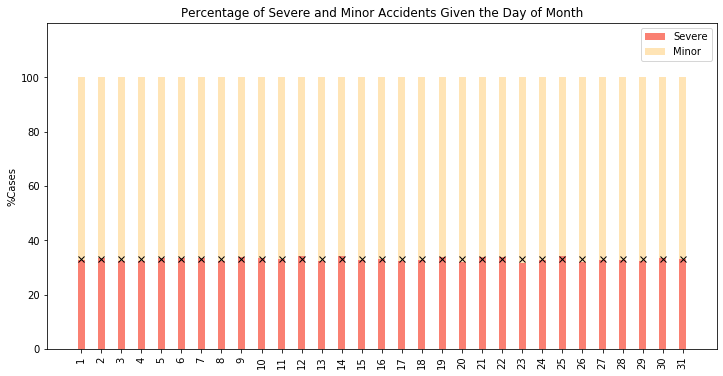

In [45]:
# show relationship to severe accidents
df_plt = df_p[df_p["SEVERITYCODE"] == 2][["DAY","SEVERITYCODE"]].groupby(["DAY"]).count()
df_plt.columns = ["severe_count"]
df_plt["minor_count"] = df_p[df_p["SEVERITYCODE"] == 1][["DAY","SEVERITYCODE"]].groupby(["DAY"]).count()
df_plt["severe%"] = (df_plt["severe_count"]/(df_plt["severe_count"] + df_plt["minor_count"]))*100
df_plt["minor%"] = (df_plt["minor_count"]/(df_plt["severe_count"] + df_plt["minor_count"]))*100
#df_plt.sort_values(by=["severe%"], ascending=False, inplace=True)

w = 0.35
plt.figure(figsize=(12,6))
ax1 = plt.bar(df_plt.index, df_plt["severe%"], color="salmon", width=w, label="Severe")
ax2 = plt.bar(df_plt.index, df_plt["minor%"], color="#FFE4B5", bottom=df_plt["severe%"], width=w, label="Minor")
for i in range(1,32):
    plt.plot(i, 100*df_p["SEVERITYCODE"].value_counts()[2]/df_p.shape[0], color="black", marker="x")
plt.ylabel("%Cases")
plt.xticks(pd.unique(df_p["DAY"]), rotation="vertical")
plt.title("Percentage of Severe and Minor Accidents Given the Day of Month")
plt.legend(loc="best")
plt.ylim(0,120)
plt.yticks(range(0,120,20))
plt.show()

<h4>DAYOFWEEK</h4>

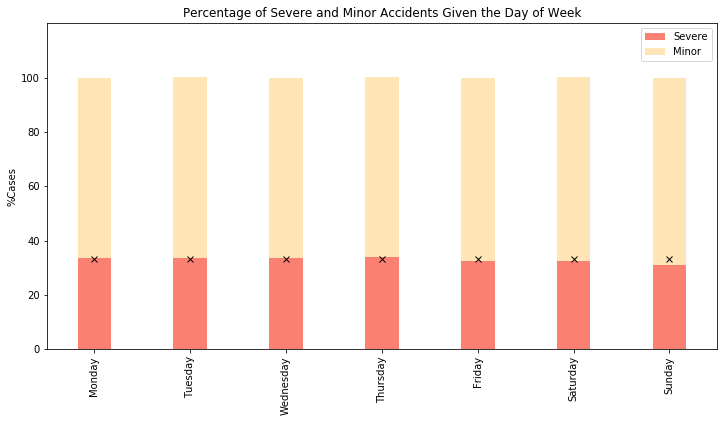

In [46]:
# show relationship to severe accidents
df_plt = df_p[df_p["SEVERITYCODE"] == 2][["DAYOFWEEK","SEVERITYCODE"]].groupby(["DAYOFWEEK"]).count()
df_plt.columns = ["severe_count"]
df_plt["minor_count"] = df_p[df_p["SEVERITYCODE"] == 1][["DAYOFWEEK","SEVERITYCODE"]].groupby(["DAYOFWEEK"]).count()
df_plt["severe%"] = (df_plt["severe_count"]/(df_plt["severe_count"] + df_plt["minor_count"]))*100
df_plt["minor%"] = (df_plt["minor_count"]/(df_plt["severe_count"] + df_plt["minor_count"]))*100
#df_plt.sort_values(by=["severe%"], ascending=False, inplace=True)

w = 0.35
plt.figure(figsize=(12,6))
ax1 = plt.bar(df_plt.index, df_plt["severe%"], color="salmon", width=w, label="Severe")
ax2 = plt.bar(df_plt.index, df_plt["minor%"], color="#FFE4B5", bottom=df_plt["severe%"], width=w, label="Minor")
for i in range(0,7):
    plt.plot(i, 100*df_p["SEVERITYCODE"].value_counts()[2]/df_p.shape[0], color="black", marker="x")
plt.ylabel("%Cases")
plt.xticks(df_plt.index, ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"],rotation="vertical")
plt.title("Percentage of Severe and Minor Accidents Given the Day of Week")
plt.legend(loc="best")
plt.ylim(0,120)
plt.yticks(range(0,120,20))
plt.show()

<h4>MONTH</h4>

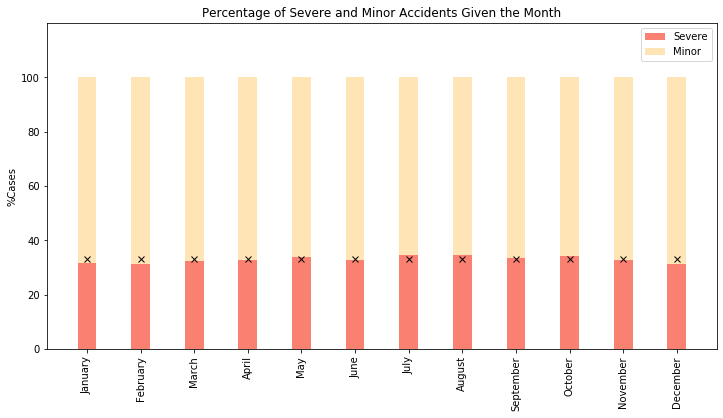

In [47]:
# show relationship to severe accidents
df_plt = df_p[df_p["SEVERITYCODE"] == 2][["MONTH","SEVERITYCODE"]].groupby(["MONTH"]).count()
df_plt.columns = ["severe_count"]
df_plt["minor_count"] = df_p[df_p["SEVERITYCODE"] == 1][["MONTH","SEVERITYCODE"]].groupby(["MONTH"]).count()
df_plt["severe%"] = (df_plt["severe_count"]/(df_plt["severe_count"] + df_plt["minor_count"]))*100
df_plt["minor%"] = (df_plt["minor_count"]/(df_plt["severe_count"] + df_plt["minor_count"]))*100
#df_plt.sort_values(by=["severe%"], ascending=False, inplace=True)

w = 0.35
plt.figure(figsize=(12,6))
ax1 = plt.bar(df_plt.index, df_plt["severe%"], color="salmon", width=w, label="Severe")
ax2 = plt.bar(df_plt.index, df_plt["minor%"], color="#FFE4B5", bottom=df_plt["severe%"], width=w, label="Minor")
for i in range(1,13):
    plt.plot(i, 100*df_p["SEVERITYCODE"].value_counts()[2]/df_p.shape[0], color="black", marker="x")
plt.ylabel("%Cases")
plt.xticks(df_plt.index, ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"], rotation="vertical")
plt.title("Percentage of Severe and Minor Accidents Given the Month")
plt.legend(loc="best")
plt.ylim(0,120)
plt.yticks(range(0,120,20))
plt.show()

<p>There doesn't seem to be a much correlation between time, day, dayofweek, month and our target data from the charts above except perhaps with time.</p>

<h4>PEDROWNOTGRNT</h4>

In [48]:
print("NaN values: ",df_p[df_p["PEDROWNOTGRNT"].isnull()].shape[0])
df_p["PEDROWNOTGRNT"].value_counts().to_frame()

NaN values:  163377


,PEDROWNOTGRNT
Y,4480


<p>Let's turn the nan values into 'N' since this feature should probably be binary</p>

In [49]:
df_p["PEDROWNOTGRNT"] = df_p["PEDROWNOTGRNT"].replace(np.nan, "N")
print("NaN values: ",df_p[df_p["PEDROWNOTGRNT"].isnull()].shape[0])

NaN values:  0


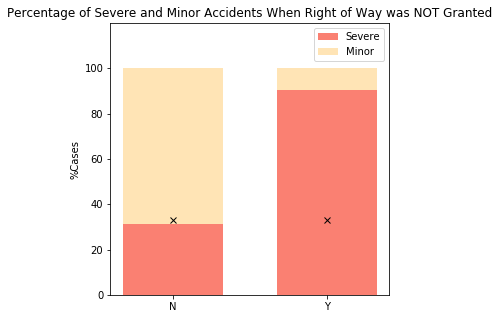

In [50]:
# show relationship to severe accidents
df_plt = df_p[df_p["SEVERITYCODE"] == 2][["PEDROWNOTGRNT","SEVERITYCODE"]].groupby(["PEDROWNOTGRNT"]).count()
df_plt.columns = ["severe_count"]
df_plt["minor_count"] = df_p[df_p["SEVERITYCODE"] == 1][["PEDROWNOTGRNT","SEVERITYCODE"]].groupby(["PEDROWNOTGRNT"]).count()
df_plt["severe%"] = (df_plt["severe_count"]/(df_plt["severe_count"] + df_plt["minor_count"]))*100
df_plt["minor%"] = (df_plt["minor_count"]/(df_plt["severe_count"] + df_plt["minor_count"]))*100

w = 0.65
plt.figure(figsize=(5,5))
ax1 = plt.bar(df_plt.index, df_plt["severe%"], color="salmon", width=w, label="Severe")
ax2 = plt.bar(df_plt.index, df_plt["minor%"], color="#FFE4B5", bottom=df_plt["severe%"], width=w, label="Minor")
for i in range(0,2):
    plt.plot(i, 100*df_p["SEVERITYCODE"].value_counts()[2]/df_p.shape[0], color="black", marker="x")
plt.ylabel("%Cases")
plt.xticks(df_plt.index)
plt.title("Percentage of Severe and Minor Accidents When Right of Way was NOT Granted")
plt.legend(loc="best")
plt.ylim(0,120)
plt.yticks(range(0,120,20))
plt.savefig("weather_severe_minor_barchart.png")
plt.show()

<p>When right of way isn't granted the probability of severe accidents dramatically increases</p>
<p>Let's convert ['N','Y'] to [0,1]</p>

In [51]:
df_p["PEDROWNOTGRNT"] = df_p["PEDROWNOTGRNT"].replace(["N","Y"], [0,1])

<h4>HITPARKEDCAR</h4>

In [52]:
print("NaN values: ",df_p[df_p["HITPARKEDCAR"].isnull()].shape[0])
df_p["HITPARKEDCAR"].value_counts().to_frame()

NaN values:  0


,HITPARKEDCAR
N,163397
Y,4460


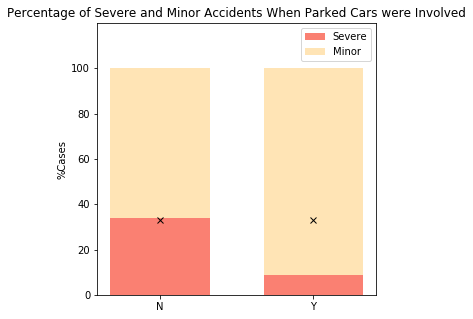

In [53]:
# show relationship to severe accidents
df_plt = df_p[df_p["SEVERITYCODE"] == 2][["HITPARKEDCAR","SEVERITYCODE"]].groupby(["HITPARKEDCAR"]).count()
df_plt.columns = ["severe_count"]
df_plt["minor_count"] = df_p[df_p["SEVERITYCODE"] == 1][["HITPARKEDCAR","SEVERITYCODE"]].groupby(["HITPARKEDCAR"]).count()
df_plt["severe%"] = (df_plt["severe_count"]/(df_plt["severe_count"] + df_plt["minor_count"]))*100
df_plt["minor%"] = (df_plt["minor_count"]/(df_plt["severe_count"] + df_plt["minor_count"]))*100

w = 0.65
plt.figure(figsize=(5,5))
ax1 = plt.bar(df_plt.index, df_plt["severe%"], color="salmon", width=w, label="Severe")
ax2 = plt.bar(df_plt.index, df_plt["minor%"], color="#FFE4B5", bottom=df_plt["severe%"], width=w, label="Minor")
for i in range(0,2):
    plt.plot(i, 100*df_p["SEVERITYCODE"].value_counts()[2]/df_p.shape[0], color="black", marker="x")
plt.ylabel("%Cases")
plt.xticks(df_plt.index)
plt.title("Percentage of Severe and Minor Accidents When Parked Cars were Involved")
plt.legend(loc="best")
plt.ylim(0,120)
plt.yticks(range(0,120,20))
plt.savefig("weather_severe_minor_barchart.png")
plt.show()

<p>Probability of severe accident is low if parked cars are hit</p>
<p>Convert ["Y","N"] to [1,0]</p>

In [54]:
df_p["HITPARKEDCAR"] = df_p["HITPARKEDCAR"].replace(["Y","N"], [1,0])

<h4>SEGLANEKEY</h4>

In [55]:
print("NaN values: ", df_p[df_p["SEGLANEKEY"].isnull()].shape[0])
print("Total Rows: ", df_p["SEGLANEKEY"].shape[0])
df_p["SEGLANEKEY"].value_counts().to_frame()

NaN values:  0
Total Rows:  167857


,SEGLANEKEY
0,165223
6532,19
6078,16
12162,14
10336,14
...,...
37987,1
35157,1
10817,1
15043,1


<p>Since there are very few observations > 0 we will convert all of them into 1</p>

In [56]:
df_p["SEGLANEKEY"] = df_p["SEGLANEKEY"].replace(pd.unique(df_p["SEGLANEKEY"])[1:].tolist(), 1)
df_p["SEGLANEKEY"].value_counts().to_frame()

,SEGLANEKEY
0,165223
1,2634


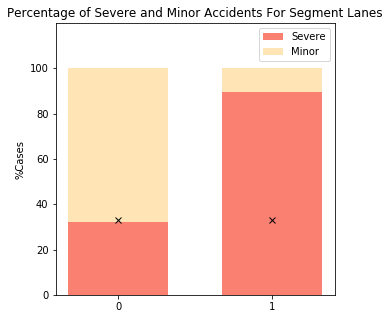

In [57]:
# show relationship to severe accidents
df_plt = df_p[df_p["SEVERITYCODE"] == 2][["SEGLANEKEY","SEVERITYCODE"]].groupby(["SEGLANEKEY"]).count()
df_plt.columns = ["severe_count"]
df_plt["minor_count"] = df_p[df_p["SEVERITYCODE"] == 1][["SEGLANEKEY","SEVERITYCODE"]].groupby(["SEGLANEKEY"]).count()
df_plt["severe%"] = (df_plt["severe_count"]/(df_plt["severe_count"] + df_plt["minor_count"]))*100
df_plt["minor%"] = (df_plt["minor_count"]/(df_plt["severe_count"] + df_plt["minor_count"]))*100

w = 0.65
plt.figure(figsize=(5,5))
ax1 = plt.bar(df_plt.index, df_plt["severe%"], color="salmon", width=w, label="Severe")
ax2 = plt.bar(df_plt.index, df_plt["minor%"], color="#FFE4B5", bottom=df_plt["severe%"], width=w, label="Minor")
for i in range(0,2):
    plt.plot(i, 100*df_p["SEVERITYCODE"].value_counts()[2]/df_p.shape[0], color="black", marker="x")
plt.ylabel("%Cases")
plt.xticks(df_plt.index)
plt.title("Percentage of Severe and Minor Accidents For Segment Lanes")
plt.legend(loc="best")
plt.ylim(0,120)
plt.yticks(range(0,120,20))
plt.savefig("weather_severe_minor_barchart.png")
plt.show()

<h4>CROSSWALKKEY</h4>

In [58]:
print("NaN values: ", df_p[df_p["CROSSWALKKEY"].isnull()].shape[0])
print("Total Rows: ", df_p["CROSSWALKKEY"].shape[0])
df_p["CROSSWALKKEY"].value_counts().to_frame()

NaN values:  0
Total Rows:  167857


,CROSSWALKKEY
0,164262
523609,16
520838,14
525567,13
523699,10
...,...
577500,1
29000,1
522373,1
631282,1


<p>We will do the same as before</p>

In [59]:
df_p["CROSSWALKKEY"] = df_p["CROSSWALKKEY"].replace(pd.unique(df_p["CROSSWALKKEY"])[1:].tolist(), 1)
df_p["CROSSWALKKEY"].value_counts().to_frame()

,CROSSWALKKEY
0,164262
1,3595


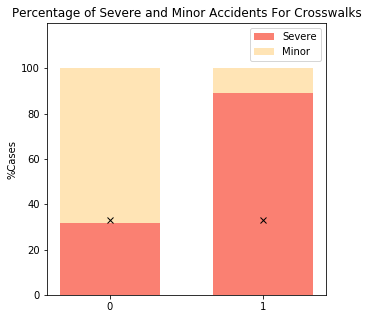

In [60]:
# show relationship to severe accidents
df_plt = df_p[df_p["SEVERITYCODE"] == 2][["CROSSWALKKEY","SEVERITYCODE"]].groupby(["CROSSWALKKEY"]).count()
df_plt.columns = ["severe_count"]
df_plt["minor_count"] = df_p[df_p["SEVERITYCODE"] == 1][["CROSSWALKKEY","SEVERITYCODE"]].groupby(["CROSSWALKKEY"]).count()
df_plt["severe%"] = (df_plt["severe_count"]/(df_plt["severe_count"] + df_plt["minor_count"]))*100
df_plt["minor%"] = (df_plt["minor_count"]/(df_plt["severe_count"] + df_plt["minor_count"]))*100

w = 0.65
plt.figure(figsize=(5,5))
ax1 = plt.bar(df_plt.index, df_plt["severe%"], color="salmon", width=w, label="Severe")
ax2 = plt.bar(df_plt.index, df_plt["minor%"], color="#FFE4B5", bottom=df_plt["severe%"], width=w, label="Minor")
for i in range(0,2):
    plt.plot(i, 100*df_p["SEVERITYCODE"].value_counts()[2]/df_p.shape[0], color="black", marker="x")
plt.ylabel("%Cases")
plt.xticks(df_plt.index)
plt.title("Percentage of Severe and Minor Accidents For Crosswalks")
plt.legend(loc="best")
plt.ylim(0,120)
plt.yticks(range(0,120,20))
plt.savefig("weather_severe_minor_barchart.png")
plt.show()

<h4>PEDCYLCOUNT</h4>

In [61]:
print("NaN values: ",df_p[df_p["PEDCYLCOUNT"].isnull()].shape[0])
df_p["PEDCYLCOUNT"].value_counts().to_frame()

NaN values:  0


,PEDCYLCOUNT
0,162591
1,5225
2,41


In [62]:
# show relationship to severe accidents
df_plt = df_p[df_p["SEVERITYCODE"] == 2][["PEDCYLCOUNT","SEVERITYCODE"]].groupby(["PEDCYLCOUNT"]).count()
df_plt.columns = ["severe_count"]
df_plt["minor_count"] = df_p[df_p["SEVERITYCODE"] == 1][["PEDCYLCOUNT","SEVERITYCODE"]].groupby(["PEDCYLCOUNT"]).count()
df_plt["minor_count"] = df_plt["minor_count"].replace(np.nan, 0)
df_plt["severe%"] = (df_plt["severe_count"]/(df_plt["severe_count"] + df_plt["minor_count"]))*100
df_plt["minor%"] = (df_plt["minor_count"]/(df_plt["severe_count"] + df_plt["minor_count"]))*100
df_plt

,severe_count,minor_count,severe%,minor%
PEDCYLCOUNT,,,,
0,50834,111757.0,31.264953,68.735047
1,4610,615.0,88.229665,11.770335
2,41,0.0,100.000000,0.000000


<p>From the above table we see that the values of 1, 2 have a high percentage of severe accidents which is almost identical. We can put them together so that we can turn this feature into binary.</p>

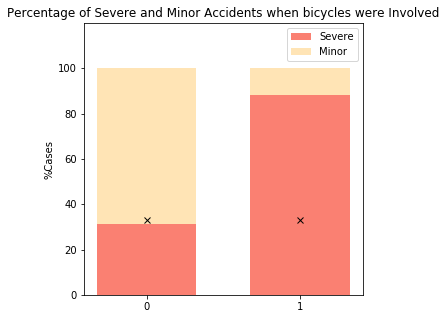

In [63]:
df_p["PEDCYLCOUNT"] = df_p["PEDCYLCOUNT"].replace(2, 1)
# show relationship to severe accidents
df_plt = df_p[df_p["SEVERITYCODE"] == 2][["PEDCYLCOUNT","SEVERITYCODE"]].groupby(["PEDCYLCOUNT"]).count()
df_plt.columns = ["severe_count"]
df_plt["minor_count"] = df_p[df_p["SEVERITYCODE"] == 1][["PEDCYLCOUNT","SEVERITYCODE"]].groupby(["PEDCYLCOUNT"]).count()
df_plt["severe%"] = (df_plt["severe_count"]/(df_plt["severe_count"] + df_plt["minor_count"]))*100
df_plt["minor%"] = (df_plt["minor_count"]/(df_plt["severe_count"] + df_plt["minor_count"]))*100

w = 0.65
plt.figure(figsize=(5,5))
ax1 = plt.bar(df_plt.index, df_plt["severe%"], color="salmon", width=w, label="Severe")
ax2 = plt.bar(df_plt.index, df_plt["minor%"], color="#FFE4B5", bottom=df_plt["severe%"], width=w, label="Minor")
for i in range(0,2):
    plt.plot(i, 100*df_p["SEVERITYCODE"].value_counts()[2]/df_p.shape[0], color="black", marker="x")
plt.ylabel("%Cases")
plt.xticks(df_plt.index)
plt.title("Percentage of Severe and Minor Accidents when bicycles were Involved")
plt.legend(loc="best")
plt.ylim(0,120)
plt.yticks(range(0,120,20))
plt.savefig("weather_severe_minor_barchart.png")
plt.show()

<h4>PEDCOUNT</h4>

In [64]:
print("NaN values: ",df_p[df_p["PEDCOUNT"].isnull()].shape[0])
df_p["PEDCOUNT"].value_counts().to_frame()

NaN values:  0


,PEDCOUNT
0,161264
1,6344
2,221
3,22
4,4
6,1
5,1


In [65]:
# show relationship to severe accidents
df_plt = df_p[df_p["SEVERITYCODE"] == 2][["PEDCOUNT","SEVERITYCODE"]].groupby(["PEDCOUNT"]).count()
df_plt.columns = ["severe_count"]
df_plt["minor_count"] = df_p[df_p["SEVERITYCODE"] == 1][["PEDCOUNT","SEVERITYCODE"]].groupby(["PEDCOUNT"]).count()
df_plt["minor_count"] = df_plt["minor_count"].replace(np.nan, 0)
df_plt["severe%"] = (df_plt["severe_count"]/(df_plt["severe_count"] + df_plt["minor_count"]))*100
df_plt["minor%"] = (df_plt["minor_count"]/(df_plt["severe_count"] + df_plt["minor_count"]))*100
df_plt

,severe_count,minor_count,severe%,minor%
PEDCOUNT,,,,
0,49548,111716.0,30.724774,69.275226
1,5707,637.0,89.959016,10.040984
2,203,18.0,91.855204,8.144796
3,21,1.0,95.454545,4.545455
4,4,0.0,100.000000,0.000000
5,1,0.0,100.000000,0.000000
6,1,0.0,100.000000,0.000000


<p>It's obvious that when there where pedestrians involved the severity was very high. We can put together all values not equal to 0 in order to turn this into a binary feature.</p>

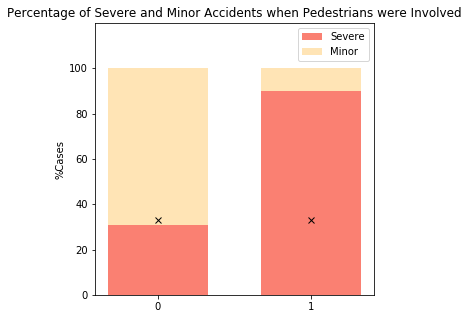

In [66]:
df_p["PEDCOUNT"] = df_p["PEDCOUNT"].replace([2,3,4,5,6], 1)

# show relationship to severe accidents
df_plt = df_p[df_p["SEVERITYCODE"] == 2][["PEDCOUNT","SEVERITYCODE"]].groupby(["PEDCOUNT"]).count()
df_plt.columns = ["severe_count"]
df_plt["minor_count"] = df_p[df_p["SEVERITYCODE"] == 1][["PEDCOUNT","SEVERITYCODE"]].groupby(["PEDCOUNT"]).count()
df_plt["severe%"] = (df_plt["severe_count"]/(df_plt["severe_count"] + df_plt["minor_count"]))*100
df_plt["minor%"] = (df_plt["minor_count"]/(df_plt["severe_count"] + df_plt["minor_count"]))*100

w = 0.65
plt.figure(figsize=(5,5))
ax1 = plt.bar(df_plt.index, df_plt["severe%"], color="salmon", width=w, label="Severe")
ax2 = plt.bar(df_plt.index, df_plt["minor%"], color="#FFE4B5", bottom=df_plt["severe%"], width=w, label="Minor")
for i in range(0,2):
    plt.plot(i, 100*df_p["SEVERITYCODE"].value_counts()[2]/df_p.shape[0], color="black", marker="x")
plt.ylabel("%Cases")
plt.xticks(df_plt.index)
plt.title("Percentage of Severe and Minor Accidents when Pedestrians were Involved")
plt.legend(loc="best")
plt.ylim(0,120)
plt.yticks(range(0,120,20))
plt.savefig("weather_severe_minor_barchart.png")
plt.show()

<h4>VEHCOUNT</h4>

In [67]:
print("NaN values: ",df_p[df_p["VEHCOUNT"].isnull()].shape[0])
df_p["VEHCOUNT"].value_counts().to_frame()

NaN values:  0


,VEHCOUNT
2,127917
1,24147
3,12512
4,2354
5,517
0,191
6,141
7,45
8,15
9,9


In [68]:
# show relationship to severe accidents
df_plt = df_p[df_p["SEVERITYCODE"] == 2][["VEHCOUNT","SEVERITYCODE"]].groupby(["VEHCOUNT"]).count()
df_plt.columns = ["severe_count"]
df_plt["minor_count"] = df_p[df_p["SEVERITYCODE"] == 1][["VEHCOUNT","SEVERITYCODE"]].groupby(["VEHCOUNT"]).count()
df_plt["minor_count"] = df_plt["minor_count"].replace(np.nan, 0)
df_plt["severe%"] = (df_plt["severe_count"]/(df_plt["severe_count"] + df_plt["minor_count"]))*100
df_plt["minor%"] = (df_plt["minor_count"]/(df_plt["severe_count"] + df_plt["minor_count"]))*100
df_plt

,severe_count,minor_count,severe%,minor%
VEHCOUNT,,,,
0,188,3.0,98.429319,1.570681
1,13532,10615.0,56.040088,43.959912
2,34961,92956.0,27.331004,72.668996
3,5382,7130.0,43.014706,56.985294
4,1066,1288.0,45.284622,54.715378
5,259,258.0,50.096712,49.903288
6,59,82.0,41.843972,58.156028
7,22,23.0,48.888889,51.111111
8,5,10.0,33.333333,66.666667


<p>We can create 3 categories instead, for category 0 we will have the cases where vehicles involved were either none or just 1, category 1 will have all cases where vehicles were 2 and category 3 will mean that vehicles count was greater than 2. This is done because of the similarity of the values = [0,1] and [3,4,5,...]. </p>

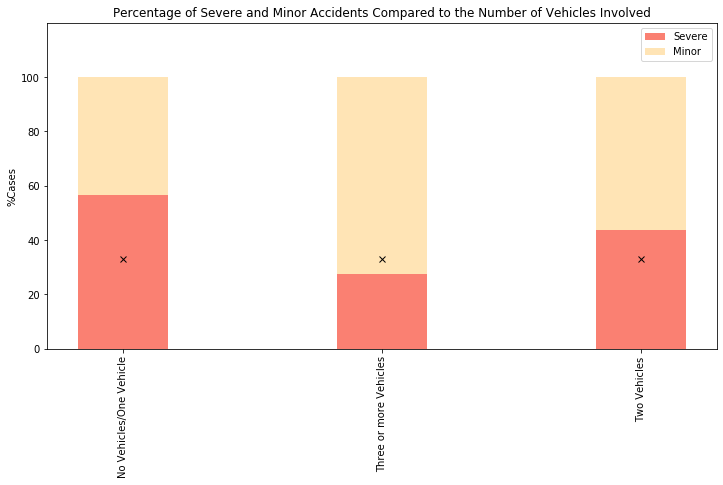

In [69]:
df_p["VEHCOUNT"] = df_p["VEHCOUNT"].replace(1, 0)
df_p["VEHCOUNT"] = df_p["VEHCOUNT"].replace(2, 1)
df_p["VEHCOUNT"] = df_p["VEHCOUNT"].replace([3,4,5,6,7,8,9,10,11], 2)

# show relationship to severe accidents
df_plt = df_p[df_p["SEVERITYCODE"] == 2][["VEHCOUNT","SEVERITYCODE"]].groupby(["VEHCOUNT"]).count()
df_plt.columns = ["severe_count"]
df_plt["minor_count"] = df_p[df_p["SEVERITYCODE"] == 1][["VEHCOUNT","SEVERITYCODE"]].groupby(["VEHCOUNT"]).count()
df_plt["severe%"] = (df_plt["severe_count"]/(df_plt["severe_count"] + df_plt["minor_count"]))*100
df_plt["minor%"] = (df_plt["minor_count"]/(df_plt["severe_count"] + df_plt["minor_count"]))*100
df_plt.sort_values(by=["severe%"], ascending=False, inplace=True)

w = 0.35
plt.figure(figsize=(12,6))
ax1 = plt.bar(df_plt.index, df_plt["severe%"], color="salmon", width=w, label="Severe")
ax2 = plt.bar(df_plt.index, df_plt["minor%"], color="#FFE4B5", bottom=df_plt["severe%"], width=w, label="Minor")
for i in range(0,3):
    plt.plot(i, 100*df_p["SEVERITYCODE"].value_counts()[2]/df_p.shape[0], color="black", marker="x")
plt.ylabel("%Cases")
plt.xticks(df_plt.index, ["No Vehicles/One Vehicle", "Two Vehicles", "Three or more Vehicles"], rotation="vertical")
plt.title("Percentage of Severe and Minor Accidents Compared to the Number of Vehicles Involved")
plt.legend(loc="best")
plt.ylim(0,120)
plt.yticks(range(0,120,20))
plt.savefig("weather_severe_minor_barchart.png")
plt.show()

<h4>Location</h4>

In [70]:
print("NaN values: ",df_p[df_p["X"].isnull()].shape[0])
print("NaN values: ",df_p[df_p["Y"].isnull()].shape[0])


NaN values:  2654
NaN values:  2654


In [71]:
df_p.dropna(subset=["X"], axis=0, inplace=True)
print("NaN values: ",df_p[df_p["X"].isnull()].shape[0])
print("NaN values: ",df_p[df_p["Y"].isnull()].shape[0])
locmean = [df_p["Y"].mean(), df_p["X"].mean()]

NaN values:  0
NaN values:  0


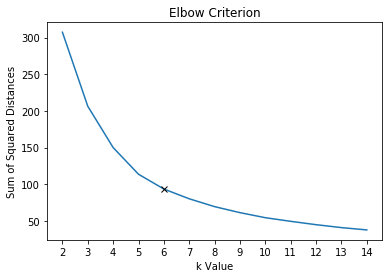

In [72]:
from sklearn.cluster import KMeans

distance_mat = []

for k in range(2, 15):
    km = KMeans(init="k-means++", n_clusters=k, n_init= 15)
    km.fit(df_p[["X","Y"]])
    distance_mat.append(km.inertia_)
plt.plot(range(2,15), distance_mat)
plt.plot(6, distance_mat[4], marker="x", color="black")
plt.xlabel("k Value")
plt.xticks(range(2,15))
plt.ylabel("Sum of Squared Distances")
plt.title("Elbow Criterion")
plt.show()

In [73]:
km = KMeans(init="k-means++", n_clusters=6, n_init=15)
km.fit(df_p[["X","Y"]])
df_p["LOCATIONCLUSTER"] = km.labels_
df_p.drop(columns=["X","Y"], inplace=True)

In [74]:
mp = folium.Map(location=locmean, zoom_start=11)
for i in range(6):
    pt = folium.map.FeatureGroup()
    pt.add_child(folium.features.CircleMarker([km.cluster_centers_[i][1],km.cluster_centers_[i][0]], radius=3, color="blue", fill_color="blue"))
    mp.add_child(pt)
mp

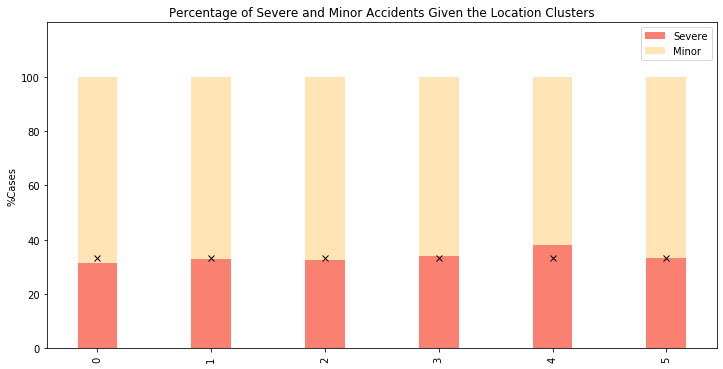

In [75]:
# show relationship to severe accidents
df_plt = df_p[df_p["SEVERITYCODE"] == 2][["LOCATIONCLUSTER","SEVERITYCODE"]].groupby(["LOCATIONCLUSTER"]).count()
df_plt.columns = ["severe_count"]
df_plt["minor_count"] = df_p[df_p["SEVERITYCODE"] == 1][["LOCATIONCLUSTER","SEVERITYCODE"]].groupby(["LOCATIONCLUSTER"]).count()
df_plt["severe%"] = (df_plt["severe_count"]/(df_plt["severe_count"] + df_plt["minor_count"]))*100
df_plt["minor%"] = (df_plt["minor_count"]/(df_plt["severe_count"] + df_plt["minor_count"]))*100
df_plt.sort_values(by=["severe%"], ascending=False, inplace=True)


w = 0.35
plt.figure(figsize=(12,6))
ax1 = plt.bar(df_plt.index, df_plt["severe%"], color="salmon", width=w, label="Severe")
ax2 = plt.bar(df_plt.index, df_plt["minor%"], color="#FFE4B5", bottom=df_plt["severe%"], width=w, label="Minor")
for i in range(0,6):
    plt.plot(i, 100*df_p["SEVERITYCODE"].value_counts()[2]/df_p.shape[0], color="black", marker="x")
plt.ylabel("%Cases")
plt.xticks(df_plt.index, rotation="vertical")
plt.title("Percentage of Severe and Minor Accidents Given the Location Clusters")
plt.legend(loc="best")
plt.ylim(0,120)
plt.yticks(range(0,120,20))
plt.savefig("weather_severe_minor_barchart.png")
plt.show()

<h4>Balancing the Data</h4>
<p>Lastly, we have to balance our data since our target data is consisted of ~67% of class 1 and ~33% of class 2</p>
<p>To do that we will use down-sampling which means that we will take a random sample without replacement from the rows containing "SEVERITYCODE" = 1 values which will have the same size as the sum of all rows containing "SEVERITYCODE" = 2 values.</p>

In [76]:
df_p["SEVERITYCODE"].value_counts()/df_p.shape[0]

1    0.668953
2    0.331047
Name: SEVERITYCODE, dtype: float64

In [77]:
df_bal = df_p[df_p["SEVERITYCODE"]==1].sample(df_p[df_p["SEVERITYCODE"]==2].shape[0])
svr_2 = df_p[df_p["SEVERITYCODE"]==2]
df_bal = df_bal.append(svr_2, ignore_index=True)
df_bal["SEVERITYCODE"].value_counts()

2    54690
1    54690
Name: SEVERITYCODE, dtype: int64

<h4>Feature Correlation</h4>
<p>It is important to check the correlation between each feature and the target data. It is also interesting to see how each feature correlates with the rest of the features, two strongly correlated features would contain the same type of information which me one of them is obsolete</p>
<p>Our features were all categorical therefore we can't use pearson's correlation coefficient. Instead we are going to use Cramer's V as our correlation metric, more information can be found <a href="https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V">here</a>. We will define the function which calculates the coefficient bellow and then we will see the correlation table and a heatmap in order to visualize the results</p>

In [78]:
cor_mat = df_p.corr(method=cramers_v)
cor_mat

,SEVERITYCODE,WEATHER,SPEEDING,LIGHTCOND,ROADCOND,JUNCTIONTYPE,ADDRTYPE,INTKEY,PEDROWNOTGRNT,HITPARKEDCAR,SEGLANEKEY,CROSSWALKKEY,PEDCYLCOUNT,PEDCOUNT,VEHCOUNT,DAY,DAYOFWEEK,MONTH,HOUR,LOCATIONCLUSTER
SEVERITYCODE,1.000000,0.020040,0.026660,0.037435,0.028274,0.186719,0.174428,0.297816,0.203360,0.085575,0.152393,0.177488,0.212266,0.245886,0.232022,0.015219,0.021258,0.023514,0.061298,0.043400
WEATHER,0.020040,1.000000,0.057463,0.033503,0.282858,0.011672,0.018691,0.211512,0.007949,0.014205,0.009921,0.006573,0.014779,0.005959,0.011228,0.023649,0.014183,0.054139,0.035360,0.011389
SPEEDING,0.026660,0.057463,1.000000,0.087903,0.159987,0.087093,0.069946,0.235505,0.031608,0.019343,0.015649,0.028933,0.023570,0.037707,0.151084,0.012711,0.039860,0.040571,0.099558,0.090877
LIGHTCOND,0.037435,0.033503,0.087903,1.000000,0.075714,0.035711,0.039345,0.217614,0.015770,0.040994,0.027858,0.018156,0.043775,0.026627,0.060869,0.015101,0.060396,0.107664,0.346512,0.027079
ROADCOND,0.028274,0.282858,0.159987,0.075714,1.000000,0.027397,0.047656,0.205794,0.017033,0.024410,0.030625,0.023459,0.043443,0.024054,0.037232,0.027493,0.014789,0.140920,0.045300,0.025791
JUNCTIONTYPE,0.186719,0.011672,0.087093,0.035711,0.027397,1.000000,0.999628,0.485691,0.160923,0.155353,0.053825,0.184265,0.096687,0.148661,0.074761,0.015923,0.014940,0.020710,0.050156,0.045708
ADDRTYPE,0.174428,0.018691,0.069946,0.039345,0.047656,0.999628,1.000000,1.000000,0.151226,0.117352,0.045706,0.180650,0.078118,0.142258,0.106552,0.014426,0.011991,0.023758,0.067221,0.073774
INTKEY,0.297816,0.211512,0.235505,0.217614,0.205794,0.485691,1.000000,1.000000,0.374064,0.163840,0.320874,0.408114,0.371903,0.357648,0.215618,0.210394,0.214524,0.212607,0.212681,0.599645
PEDROWNOTGRNT,0.203360,0.007949,0.031608,0.015770,0.017033,0.160923,0.151226,0.374064,1.000000,0.027624,0.241625,0.453672,0.327805,0.502331,0.405287,0.014200,0.033374,0.026311,0.051457,0.064314
HITPARKEDCAR,0.085575,0.014205,0.019343,0.040994,0.024410,0.155353,0.117352,0.163840,0.027624,1.000000,0.019203,0.024664,0.026807,0.031640,0.076293,0.015386,0.023287,0.012342,0.081829,0.031598


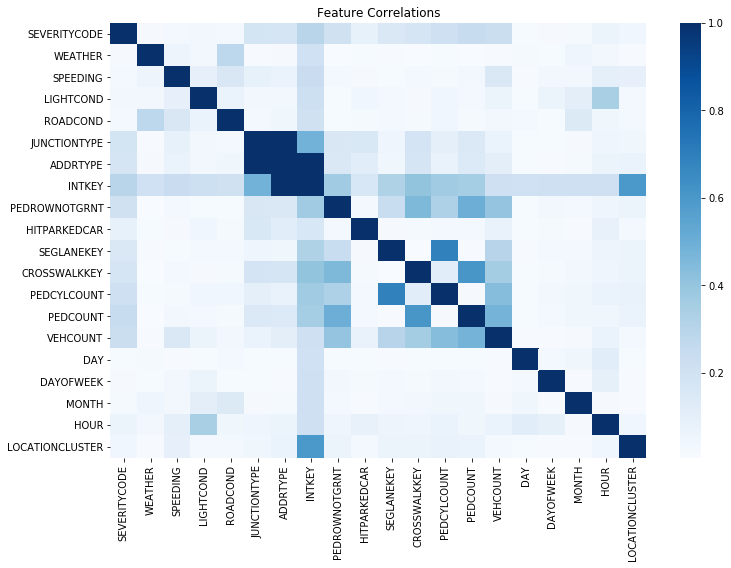

In [79]:
plt.figure(figsize=(12,8))
sns.heatmap(np.abs(cor_mat), cbar=True, cmap="Blues")
plt.title("Feature Correlations")
plt.show()

<h4>Standardization</h4>

In [80]:
scaler = StandardScaler()
for col in df_bal.columns[1:]:
    scaler.fit(df_bal[[col]])
    df_bal[col] = scaler.transform(df_bal[[col]])
df_bal.describe()

,SEVERITYCODE,WEATHER,SPEEDING,LIGHTCOND,ROADCOND,JUNCTIONTYPE,ADDRTYPE,INTKEY,PEDROWNOTGRNT,HITPARKEDCAR,SEGLANEKEY,CROSSWALKKEY,PEDCYLCOUNT,PEDCOUNT,VEHCOUNT,DAY,DAYOFWEEK,MONTH,HOUR,LOCATIONCLUSTER
count,109380.000000,1.093800e+05,1.093800e+05,1.093800e+05,1.093800e+05,1.093800e+05,1.093800e+05,1.093800e+05,1.093800e+05,1.093800e+05,1.093800e+05,1.093800e+05,1.093800e+05,1.093800e+05,1.093800e+05,1.093800e+05,1.093800e+05,1.093800e+05,1.093800e+05,1.093800e+05
mean,1.500000,1.692309e-14,-1.251312e-14,-2.171769e-14,1.753434e-15,-2.006276e-14,-1.610409e-13,2.695384e-14,-7.019625e-14,-5.304509e-14,-8.229563e-14,2.492991e-14,-1.569310e-13,2.218637e-14,1.007459e-13,6.356631e-17,4.323889e-15,5.217557e-15,-7.044913e-15,-1.734173e-14
std,0.500002,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00
min,1.000000,-2.414561e+00,-2.379231e-01,-3.467422e+00,-6.227689e-01,-1.834746e+00,-8.175389e-01,-3.884480e-01,-2.011363e-01,-1.493649e-01,-1.523758e-01,-1.790860e-01,-2.170239e-01,-2.456753e-01,-1.813414e+00,-1.668217e+00,-1.529729e+00,-1.635713e+00,-1.685026e+00,-1.068998e+00
25%,1.000000,-8.341654e-02,-2.379231e-01,-1.448457e+00,-6.227689e-01,-1.113593e+00,-8.175389e-01,-1.082285e-01,-2.011363e-01,-1.493649e-01,-1.523758e-01,-1.790860e-01,-2.170239e-01,-2.456753e-01,1.314537e-01,-8.714416e-01,-1.007154e+00,-7.527016e-01,-6.630265e-01,-1.068998e+00
50%,1.500000,-8.341654e-02,-2.379231e-01,5.705080e-01,-6.227689e-01,3.287119e-01,-8.175389e-01,5.578321e-03,-2.011363e-01,-1.493649e-01,-1.523758e-01,-1.790860e-01,-2.170239e-01,-2.456753e-01,1.314537e-01,3.915925e-02,3.799635e-02,1.303097e-01,2.129734e-01,1.591967e-02
75%,2.000000,-8.341654e-02,-2.379231e-01,5.705080e-01,1.621936e+00,1.049864e+00,1.223183e+00,5.578321e-03,-2.011363e-01,-1.493649e-01,-1.523758e-01,-1.790860e-01,-2.170239e-01,-2.456753e-01,1.314537e-01,8.359350e-01,1.083147e+00,1.013321e+00,7.969732e-01,1.100838e+00
max,2.000000,1.390345e+01,4.203038e+00,2.589473e+00,1.621936e+00,1.771017e+00,1.223183e+00,6.935276e+01,4.971752e+00,6.695014e+00,6.562720e+00,5.583910e+00,4.607788e+00,4.070413e+00,2.152500e+01,1.746536e+00,1.605722e+00,1.601995e+00,1.672973e+00,1.643297e+00


<p>Now we are going to choose which features to use for our model based on the above information</p>
<p>The following features have a relatively good correlation with the severity of the accidents:</p>
<p>["JUNCTIONTYPE","ADDRTYPE","INTKEY","PEDROWNOTGRNT","SEGLANEKEY","PEDCYLCOUNT","PEDCOUNT","VEHCOUNT","LOCATIONCLUSTER"]</p>

In [81]:
df_model = df_bal[["JUNCTIONTYPE","ADDRTYPE","INTKEY","PEDROWNOTGRNT","SEGLANEKEY","PEDCYLCOUNT","PEDCOUNT","VEHCOUNT","LOCATIONCLUSTER"]]

<h2>Model Selection and Evaluation</h2>
<p>In order to train and test our models we will first split the data into a training and a testing set.</p>
<p>We will use 10-fold-crossvalidation to train our models using the train set</p>
<p>We will then use the test set to generate evaluation metrics for each model</p>

In [82]:
X = df_model.values
y = df_bal["SEVERITYCODE"].values

In [83]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=3)
print("Training Set Size: ", xtrain.shape)
print("Test Set Size: ", xtest.shape)

Training Set Size:  (76566, 9)
Test Set Size:  (32814, 9)


<h4>K-Nearest-Neighbors</h4>

In [84]:
param = {"n_neighbors": [20,25,30]}
grid = GridSearchCV(KNeighborsClassifier(), param, cv=10)
knn = grid.fit(xtrain, ytrain)
print(jaccard_score(ytest, knn.predict(xtest)))
knn.best_estimator_

0.53788285867813


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=30, p=2,
                     weights='uniform')

<h4>Logistic Regression</h4>

In [85]:
param = {"C": [0.1, 0.2, 0.3]}
grid = GridSearchCV(LogisticRegression(), param, cv=10)
log_reg = grid.fit(xtrain, ytrain)
print(jaccard_score(ytest, log_reg.predict(xtest)))
print(log_reg.best_estimator_)
print(pd.DataFrame({"Feature": df_model.columns, "Importance": log_reg.best_estimator_.coef_[0]}).sort_values(by="Importance", ascending=False))

0.5294652826599396
LogisticRegression(C=0.3, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
           Feature  Importance
6         PEDCOUNT    0.781344
5      PEDCYLCOUNT    0.657449
7         VEHCOUNT    0.203538
8  LOCATIONCLUSTER    0.167161
4       SEGLANEKEY    0.053132
3    PEDROWNOTGRNT   -0.020038
1         ADDRTYPE   -0.139703
0     JUNCTIONTYPE   -0.296398
2           INTKEY   -2.740102


<h4>Decision Tree</h4>

In [86]:
param = {"max_depth": [5,6,7]}
grid = GridSearchCV(DecisionTreeClassifier(), param, cv=10)
dec_tree = grid.fit(xtrain, ytrain)
print(jaccard_score(ytest, dec_tree.predict(xtest)))
print(dec_tree.best_estimator_)
print(pd.DataFrame({"Feature": df_model.columns, "Importance": dec_tree.best_estimator_.feature_importances_}).sort_values(by="Importance", ascending=False))

0.5354830465155904
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
           Feature  Importance
2           INTKEY    0.463794
5      PEDCYLCOUNT    0.183038
6         PEDCOUNT    0.174541
7         VEHCOUNT    0.168082
0     JUNCTIONTYPE    0.005665
8  LOCATIONCLUSTER    0.004838
3    PEDROWNOTGRNT    0.000042
1         ADDRTYPE    0.000000
4       SEGLANEKEY    0.000000


<h4>Random Forest</h4>

In [87]:
param = {"max_depth": [5,6,7]}
grid = GridSearchCV(RandomForestClassifier(), param, cv=10)
ran_for = grid.fit(xtrain, ytrain)
print(jaccard_score(ytest, ran_for.predict(xtest)))
print(ran_for.best_estimator_)
print(pd.DataFrame({"Feature": df_model.columns, "Importance": ran_for.best_estimator_.feature_importances_}).sort_values(by="Importance", ascending=False))

0.5408635636730915
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
           Feature  Importance
2           INTKEY    0.285984
6         PEDCOUNT    0.213696
7         VEHCOUNT    0.158570
5      PEDCYLCOUNT    0.148200
0     JUNCTIONTYPE    0.072692
3    PEDROWNOTGRNT    0.035091
1         ADDRTYPE    0.031253
4       SEGLANEKEY    0.028424
8  LOCATIONCLUSTER    0.026090


<h3>Evaluation</h3>
<h4>Metrics</h4>

In [88]:
models = ["KNN", "Logistic Regression", "Decision Tree", "Random Forest"]
jac_ind = [jaccard_score(ytest, knn.predict(xtest)),
          jaccard_score(ytest, log_reg.predict(xtest)),
          jaccard_score(ytest, dec_tree.predict(xtest)),
          jaccard_score(ytest, ran_for.predict(xtest))]
f1_scr = [f1_score(ytest, knn.predict(xtest)),
          f1_score(ytest, log_reg.predict(xtest)),
          f1_score(ytest, dec_tree.predict(xtest)),
          f1_score(ytest, ran_for.predict(xtest))]
log_ls = [np.nan,
          log_loss(ytest, log_reg.predict_proba(xtest)),
          np.nan,
          np.nan]
df_eval_metrics = pd.DataFrame({"Model": models, "Jaccard Index": jac_ind, "F1-Score": f1_scr, "Log Loss": log_ls})
df_eval_metrics

,Model,Jaccard Index,F1-Score,Log Loss
0,KNN,0.537883,0.699511,NaN
1,Logistic Regression,0.529465,0.692353,0.604617
2,Decision Tree,0.535483,0.697478,NaN
3,Random Forest,0.540864,0.702027,NaN


<h4>Confusion Matrices</h4>

In [89]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

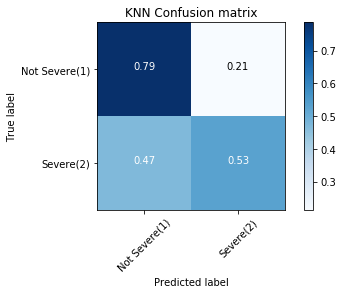

In [90]:
np.set_printoptions(precision=2)

cnf_matrix_knn = confusion_matrix(ytest, knn.predict(xtest), labels=[1,2])
cnf_matrix_logreg = confusion_matrix(ytest, log_reg.predict(xtest), labels=[1,2])
cnf_matrix_dectree = confusion_matrix(ytest, dec_tree.predict(xtest), labels=[1,2])
cnf_matrix_ranfor = confusion_matrix(ytest, ran_for.predict(xtest), labels=[1,2])



plt.figure()
plot_confusion_matrix(cnf_matrix_knn, classes=['Not Severe(1)','Severe(2)'],normalize= True,  title='KNN Confusion matrix')
plt.show()

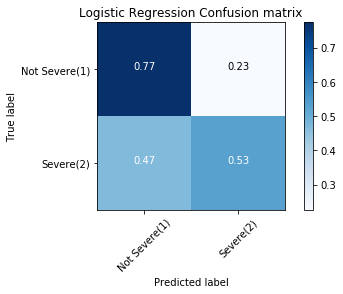

In [91]:
plot_confusion_matrix(cnf_matrix_logreg, classes=['Not Severe(1)','Severe(2)'],normalize= True,  title='Logistic Regression Confusion matrix')
plt.show()

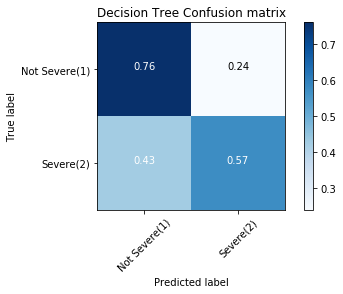

In [92]:
plot_confusion_matrix(cnf_matrix_dectree, classes=['Not Severe(1)','Severe(2)'],normalize= True,  title='Decision Tree Confusion matrix')
plt.show()

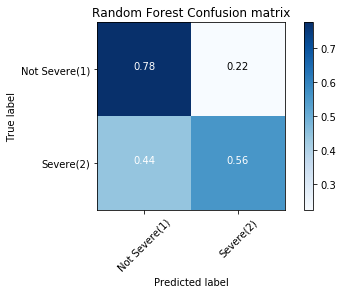

In [93]:
plot_confusion_matrix(cnf_matrix_ranfor, classes=['Not Severe(1)','Severe(2)'],normalize= True,  title='Random Forest Confusion matrix')
plt.show()